In [18]:
from IPython.display import clear_output
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import registration as reg
import segmentation as seg
import analysis as ana
import SimpleITK as sitk
import numpy as np
import utils as ut
import importlib

In [2]:
COMMON_PATH = "../data/COMMON_images_masks/common_"
GROUP_PATH = "../data/g3_"

# 1.Data Exploration

In [3]:
importlib.reload(ut)
filename = COMMON_PATH + '40_image.nii.gz'
maskname = COMMON_PATH + '40_mask.nii.gz' 
pelvic_img = ut.read_image(filename)
pelvic_mask = ut.read_image(maskname)

In [4]:
sitk.GetArrayFromImage(pelvic_img).shape

(286, 512, 512)

In [5]:
importlib.reload(ut)
filename = GROUP_PATH + '59_image.nii.gz'
maskname = GROUP_PATH + '59_mask.nii.gz' 
pelvic_img = ut.read_image(filename)
pelvic_mask = ut.read_image(maskname)

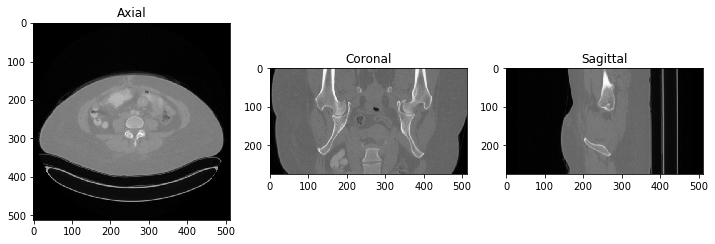

In [6]:
ut.plot_3d_img_slices(pelvic_img)

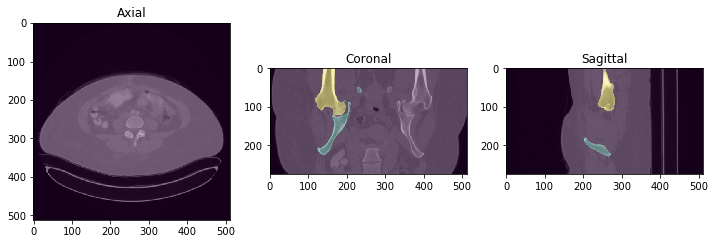

In [7]:
ut.plot_3d_img_masked(pelvic_img, pelvic_mask)

### Select only mask of interest (1 Right femur and 3 Right hip bone)

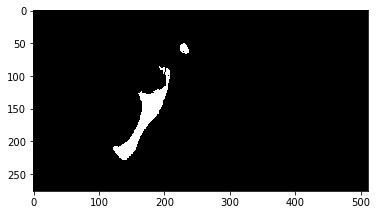

In [8]:
importlib.reload(reg)
mask_of_interest = reg.Transform.create_mask_of_interest(maskname, labels=[1,3], verbose=True)

## 1.2 Explore a Fixed and Moving Image

In [9]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

In [10]:
importlib.reload(ut)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=137, descrip…

In [11]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

# 3. Registration
## Linear Trasform: Affine Transformation 12DOF

In [12]:
im_ref_filename = COMMON_PATH + '40_image.nii.gz'
im_mov_filename = GROUP_PATH + '59_image.nii.gz'

In [13]:
%%time
importlib.reload(reg)
lin_trf = reg.LinearTransform(im_ref_filename=im_ref_filename,im_mov_filename=im_mov_filename)
lin_xfm = lin_trf.est_transf(metric="MI")

Wall time: 9.77 s


In [14]:
moving_image = lin_trf.apply_transf(lin_xfm)
fixed_image = lin_trf.im_mov
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=137, description='fixed_image_z', max=275), IntSlider(value=142, descrip…

In [15]:
fixed_image = lin_trf.im_ref
moving_image = lin_trf.apply_transf(lin_xfm)
interact(ut.display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=142, description='fixed_image_z', max=285), IntSlider(value=142, descrip…

In [16]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

moving_resampled = sitk.Resample(moving_image, fixed_image, lin_xfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

## Non Linear Transformation  FFD 

In [17]:
%%time
importlib.reload(reg)
non_lin_trf = reg.NonLinearTransform(im_ref_filename=im_ref_filename, im_mov_filename=im_mov_filename)
non_lin_trf.im_mov = moving_resampled
non_lin_xfm = non_lin_trf.est_transf(metric="SSD")

itk::simple::Transform
 BSplineTransform (000002B4E03CA520)
   RTTI typeinfo:   class itk::BSplineTransform<double,3,3>
   Reference Count: 3
   Modified Time: 3653157
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 000002B4C3210870, 000002B4C3211C20, 000002B4C32132A0 ]
   TransformDomainOrigin: [-169.083, -299.083, 728.2]
   TransformDomainPhysicalDimensions: [340.166, 340.166, 228.997]
   TransformDomainDirection: 1 0 0
0 1 0
0 0 1

   TransformDomainMeshSize: [11, 11, 8]
   GridSize: [14, 14, 11]
   GridOrigin: [-200.007, -330.007, 699.575]
   GridSpacing: [30.9242, 30.9242, 28.6246]
   GridDirection: 1 0 0
0 1 0
0 0 1


--------
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 41.
Number of iterations: 41
--------
Wall time: 9min 35s


In [18]:
fixed_image = ut.read_image(COMMON_PATH + '40_image.nii.gz')
moving_image = ut.read_image(GROUP_PATH + '59_image.nii.gz')

moving_resampled = sitk.Resample(moving_image, fixed_image, non_lin_xfm, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ut.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled))

interactive(children=(IntSlider(value=142, description='image_z', max=285), FloatSlider(value=0.5, description…

<function utils.display_images_with_alpha(image_z, alpha, fixed, moving)>

In [22]:
importlib.reload(seg)
importlib.reload(reg)
atlas_seg = seg.AtlasSegmentation()

In [23]:
atlas_seg.cmn_mask
atlas_seg.grp_mask

{59: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000025F86099450> >,
 60: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000025F860F7270> >,
 61: <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x0000025F860F7E10> >}

# Creating and saving atlas segmentations using the group image masks
#Note, I made it so that the atlas segmentation/registration uses masks during the registration.
#Made results slightly better. Only ran it for image 40 so far.

In [33]:

cmn_40_seg_saved = atlas_seg.seg_atlas(40)
np.save("../data/Images/{}_atlas_seg.npy".format(40),cmn_40_seg_saved)



In [25]:
cmn_41_seg_saved = atlas_seg.seg_atlas(41)
np.save("../data/Images/{}_atlas_seg.npy".format(41),cmn_41_seg_saved)

In [26]:
cmn_42_seg_saved = atlas_seg.seg_atlas(42)
np.save("../data/Images/{}_atlas_seg.npy".format(42),cmn_42_seg_saved)

# Looking at the atlases made for the 3 common images

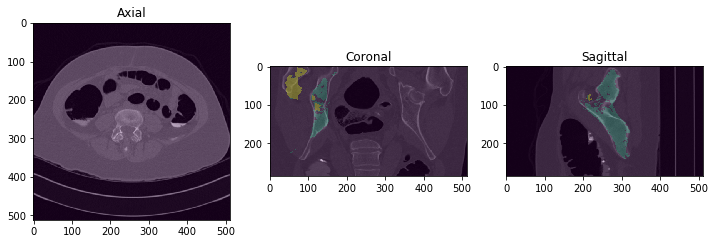

Reference mask


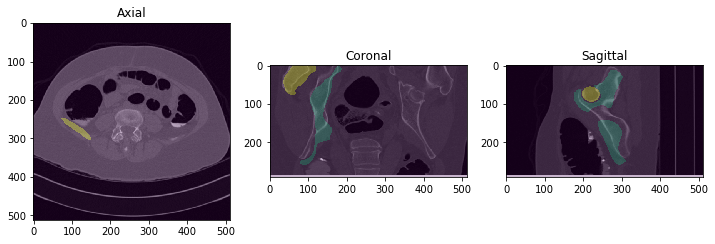

Image : 40
Atlas mask


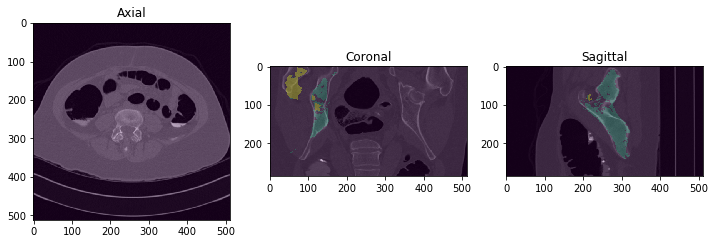

Reference mask


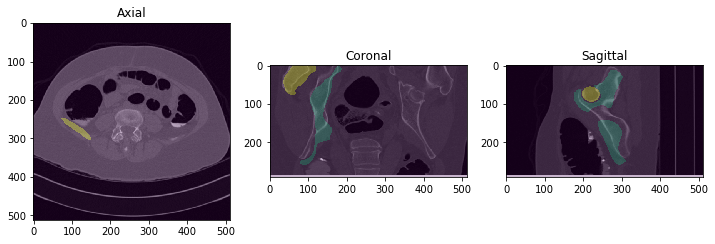

In [35]:
importlib.reload(seg)
importlib.reload(reg)
for image_id in range(40,41):
    print("Image : {}".format(image_id))

    print("Atlas mask")
    mask = np.load("../data/Images/{}_atlas_seg.npy".format(image_id))
    filename = COMMON_PATH + '{}_image.nii.gz'.format(image_id)
    image = ut.read_image(filename)
    atlas_mask = sitk.GetImageFromArray(mask)
    ut.plot_3d_img_masked(image, atlas_mask)



    print("Reference mask")
    ref_mask_name = COMMON_PATH + '{}_mask.nii.gz'.format(image_id)
    ref_mask = ut.read_image(ref_mask_name)
    mask_of_interest = reg.Transform.create_mask_of_interest(maskname, labels=[1,3], verbose=False)
    ut.plot_3d_img_masked(image, mask_of_interest )
    #Note, the reference masks look wrong for image 41 and 42.

# Checking Dice results for the atlas segmentations

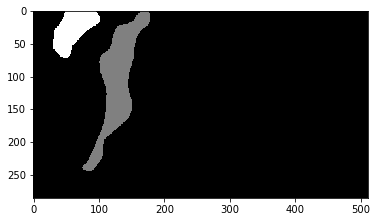

0.574331690488989


In [39]:
#
importlib.reload(ut)
importlib.reload(ana)

dice_results = []
for image_id in range(40,41):
    maskname = COMMON_PATH + '{}_mask.nii.gz'.format(image_id)
    ref_mask  = reg.Transform.create_mask_of_interest(maskname, labels=[1,3], verbose=True)
    test_mask_array = np.load("../data/Images/{}_atlas_seg.npy".format(image_id))

    test_mask = sitk.GetImageFromArray(test_mask_array)
    test_mask = sitk.Cast(test_mask, sitk.sitkInt32)
    ref_mask = sitk.Cast(ref_mask, sitk.sitkInt32)
    dice_results.append(ana.dice_analysis(test_mask, ref_mask))

# Checking HausDorf Distance for the atlas segmentations

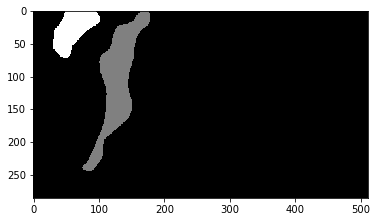

55.06359959174482


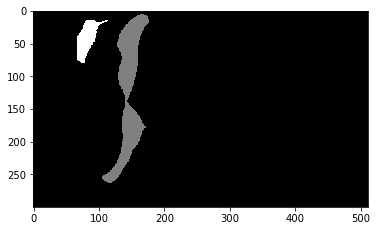

47.12748667179272


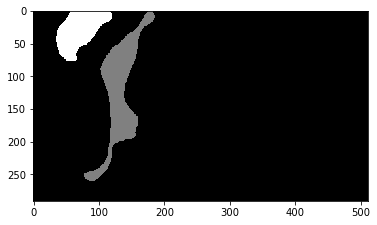

114.74319151914854


In [38]:
#
importlib.reload(ut)
importlib.reload(ana)

hdd_results = []
for image_id in range(40,43):
    maskname = COMMON_PATH + '{}_mask.nii.gz'.format(image_id)
    ref_mask  = reg.Transform.create_mask_of_interest(maskname, labels=[1,3], verbose=True)
    test_mask_array = np.load("../data/Images/{}_atlas_seg.npy".format(image_id))

    test_mask = sitk.GetImageFromArray(test_mask_array)
    test_mask = sitk.Cast(test_mask, sitk.sitkInt32)
    ref_mask = sitk.Cast(ref_mask, sitk.sitkInt32)
    hdd_results.append(ana.hausdorf_distance_analysis(test_mask, ref_mask))






